In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MOSTA'
args.max_neighbors=8
args.hvgs=2000
args.er_w=0.1
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MOSTA', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.1, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=8, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_h5ad(args.dataset_path + '/E10.5_E1S1.MOSTA.h5ad')
adata

AnnData object with n_obs × n_vars = 18408 × 25201
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 6720489N17Rik', 'Regulon - Aebp2', 'Regulon - Ahr', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arx', 'Regulon - Atf2', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Atoh1', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl2', 'Regulon - Bcl11a', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cbfb', 'Regulon - Cdc5l', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpd', 'Regulon - Cebpe', 'Regulon - Chd1', 'Regulon - Clk1', 'Regulon - Clock', 'Regulon - Cnot3', 'Regulon - Cpsf4', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l4', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon 

In [5]:
adata.obs['annotation']

cell_name
109_198    Cavity
109_199    Cavity
109_200    Cavity
110_192    Cavity
110_193    Cavity
            ...  
249_190    Cavity
249_191    Cavity
249_192    Cavity
249_193    Cavity
249_194    Cavity
Name: annotation, Length: 18408, dtype: category
Categories (13, object): ['Blood vessel', 'Brain', 'Branchial arch', 'Cavity', ..., 'Sclerotome', 'Spinal cord', 'Surface ectoderm', 'Urogenital ridge']

In [6]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='knn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

18408 2000 torch.Size([2, 167116])


In [8]:
import time
start_time = time.time()
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:1.7482, T:0.5636, S:0.4217, D:0.7629]

Epoch 100: Train[Total:0.7656, T:0.1775, S:0.1778, D:0.4103]

Epoch 200: Train[Total:0.4759, T:0.1730, S:0.1738, D:0.1291]

Epoch 300: Train[Total:0.4003, T:0.1707, S:0.1716, D:0.0580]

Epoch 400: Train[Total:0.3739, T:0.1688, S:0.1699, D:0.0351]

Epoch 500: Train[Total:0.3604, T:0.1674, S:0.1687, D:0.0243]

Epoch 600: Train[Total:0.3505, T:0.1673, S:0.1683, D:0.0149]

Epoch 700: Train[Total:0.3438, T:0.1663, S:0.1684, D:0.0091]

Epoch 800: Train[Total:0.3350, T:0.1643, S:0.1656, D:0.0052]

Epoch 900: Train[Total:0.3315, T:0.1633, S:0.1647, D:0.0036]

Epoch 999: Train[Total:0.3373, T:0.1642, S:0.1650, D:0.0082]


In [9]:
end_time = time.time()
print(f"time: {end_time - start_time:.4f} s")

time: 102.5248 s


In [10]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

In [11]:
adata_hvg

AnnData object with n_obs × n_vars = 18408 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 6720489N17Rik', 'Regulon - Aebp2', 'Regulon - Ahr', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arx', 'Regulon - Atf2', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Atoh1', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl2', 'Regulon - Bcl11a', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cbfb', 'Regulon - Cdc5l', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpd', 'Regulon - Cebpe', 'Regulon - Chd1', 'Regulon - Clk1', 'Regulon - Clock', 'Regulon - Cnot3', 'Regulon - Cpsf4', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l4', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon -

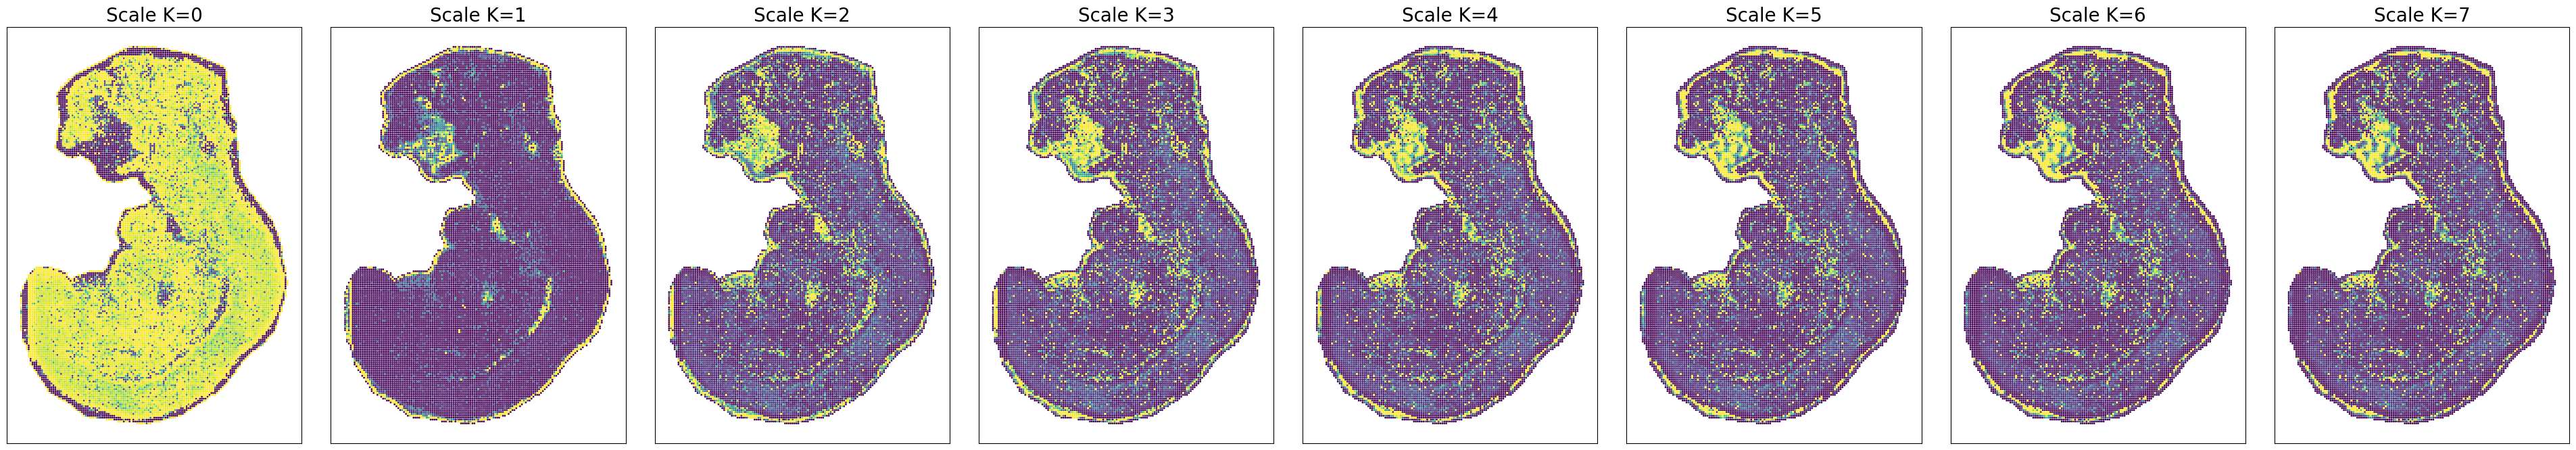

In [12]:
# show the average attention scores of multiple scales
attn_avg_heads = attn.mean(axis=-1)
for i, k in enumerate(args.k_list):
    adata_hvg.obs[f'Scale K={k}'] = attn_avg_heads[:, i]

context_params = {
    'figure.figsize': (6, 8),
    'font.size': 12,              # 全局默认字体大小
    'axes.titlesize': 20,         # 子图标题大小 (Scale K=...)
    'legend.fontsize': 10,        # 图例字体大小 (如果有)
    'axes.labelsize': 12,         # 轴标签大小
    'xtick.labelsize': 10,        # 刻度大小
    'ytick.labelsize': 10,
}

with plt.rc_context(context_params):
    axes_list = sc.pl.spatial(
        adata_hvg, 
        color=[f'Scale K={k}' for k in args.k_list],
        show=False,
        spot_size=1,
        colorbar_loc=None,
        cmap='viridis',
        ncols=8,
        vmax='p95',
        wspace=0.0, # 配合上面调整间距
    )

    if not isinstance(axes_list, list):
        axes_list = [axes_list]
    for ax in axes_list:
        ax.set_xlabel('')  # 去掉 spatial1
        ax.set_ylabel('')  # 去掉 spatial2
    plt.subplots_adjust(wspace=1, hspace=0.2)
    
    plt.show()

In [13]:
args.clusters=13
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


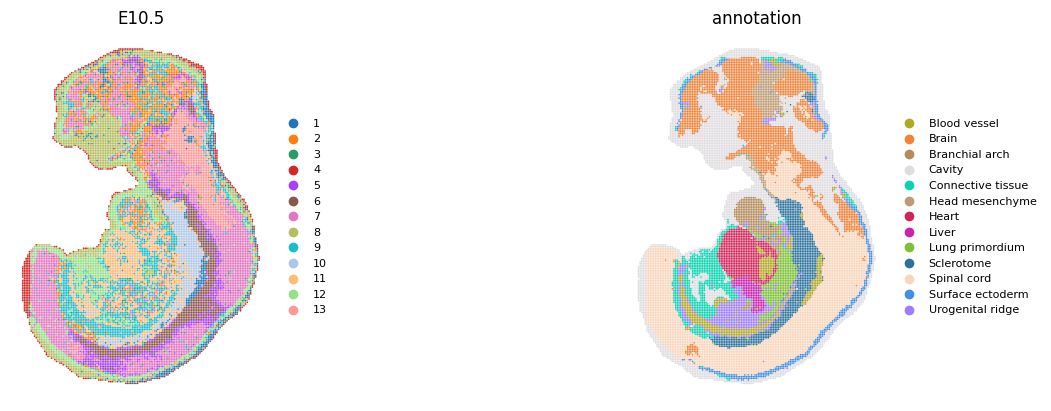

In [14]:
sc.pl.spatial(adata_hvg, img_key=None, color=['mclust','annotation'], 
              title=['E10.5'], size=1., legend_fontsize=8, 
              frameon=False, spot_size=1)